### Imports Libs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


2024-11-16 20:37:57.789966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731800277.802152   29073 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731800277.805727   29073 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 20:37:57.818919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Prepare data

In [2]:
def load_mnist():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
    x_train, x_val = x_train / 255.0, x_val / 255.0 
    x_train, x_val = tf.expand_dims(x_train, axis=-1), tf.expand_dims(x_val, axis=-1)
    return (x_train, y_train), (x_val, y_val)

In [3]:
(x_train, y_train), (x_val, y_val) = load_mnist()

print(f"training dataset dimension: {x_train.shape}, {y_train.shape}")
print(f"dataset validation dimension: {x_val.shape}, {y_val.shape}")

training dataset dimension: (60000, 28, 28, 1), (60000,)
dataset validation dimension: (10000, 28, 28, 1), (10000,)


I0000 00:00:1731800281.554485   29073 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4274 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
def create_dataloader(X, y, batch_size, shuffle=True):
    X = tf.cast(X, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(y))
    return dataset.batch(batch_size)


In [5]:
batch_size = 64
train_loader = create_dataloader(x_train, y_train, batch_size)
val_loader = create_dataloader(x_val, y_val, batch_size, shuffle=False)

In [6]:
class MLP:
    def __init__(self, input_shape, num_classes):
        self.num_classes = num_classes
        self.weights = {
            "W1": tf.Variable(tf.random.normal([28 * 28, 128], stddev=0.1, dtype=tf.float32)),
            "W2": tf.Variable(tf.random.normal([128, 64], stddev=0.1, dtype=tf.float32)),
            "W3": tf.Variable(tf.random.normal([64, num_classes], stddev=0.1, dtype=tf.float32)),
        }
        self.biases = {
            "b1": tf.Variable(tf.zeros([128], dtype=tf.float32)),
            "b2": tf.Variable(tf.zeros([64], dtype=tf.float32)),
            "b3": tf.Variable(tf.zeros([num_classes], dtype=tf.float32)),
        }


    def forward(self, x):
        x = tf.reshape(x, [-1, 28 * 28])  # Achatar a entrada
        h1 = tf.nn.relu(tf.matmul(x, self.weights["W1"]) + self.biases["b1"])
        h2 = tf.nn.relu(tf.matmul(h1, self.weights["W2"]) + self.biases["b2"])
        out = tf.matmul(h2, self.weights["W3"]) + self.biases["b3"]
        return out

    def predict(self, x):
        logits = self.forward(x)
        return tf.argmax(logits, axis=1)

In [7]:
mlp = MLP(input_shape=(28, 28, 1), num_classes=10)

In [8]:
def cross_entropy_loss(logits, labels):
    labels = tf.cast(labels, dtype=tf.int32)
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))


optimizer = tf.optimizers.Adam()

In [9]:
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        logits = model.forward(tf.cast(x, dtype=tf.float32))
        loss = cross_entropy_loss(logits, y)
    gradients = tape.gradient(loss, list(model.weights.values()) + list(model.biases.values()))
    optimizer.apply_gradients(zip(gradients, list(model.weights.values()) + list(model.biases.values())))
    return loss

In [10]:
def evaluate(model, dataloader):
    correct = 0
    total = 0
    for x, y in dataloader:
        preds = model.predict(x)
        # Converta os tensores para int64 antes da comparação
        correct += tf.reduce_sum(tf.cast(tf.equal(tf.cast(preds, tf.int64), tf.cast(y, tf.int64)), tf.int32)).numpy()
        total += x.shape[0]
    return correct / total


In [11]:
epochs = 5
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:  # Certifique-se de que os dados estão corretos
        loss = train_step(mlp, x_batch, y_batch)
    accuracy = evaluate(mlp, val_loader)  # Validação
    print(f"Época {epoch + 1}, Acurácia: {accuracy:.4f}")


2024-11-16 20:38:19.032371: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-16 20:38:19.298509: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 1, Acurácia: 0.9595


2024-11-16 20:38:36.208856: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 2, Acurácia: 0.9670
Época 3, Acurácia: 0.9700


2024-11-16 20:39:09.372751: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 4, Acurácia: 0.9727
Época 5, Acurácia: 0.9752


In [12]:
imgs,label, y_pred, y_true = [], [], [], []
for x_batch, y_batch in val_loader:
    y_pred.extend(mlp.predict(x_batch).numpy())
    imgs.extend(x_batch)
    label.extend(y_batch)
    y_true.extend(y_batch.numpy())

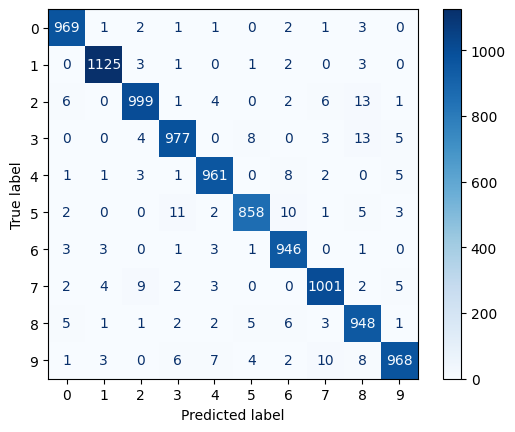

In [13]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
y_pred2 = np.atleast_1d(y_pred)
y_true2 = np.atleast_1d(y_true)


differences = np.nonzero(y_pred2 != y_true2)[0]
index = 0


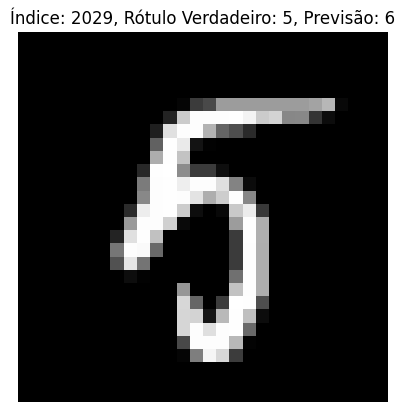

In [79]:
i = differences[index]
img = imgs[i]
true_label = label[i].numpy()  
predicted_label = y_pred[i]

# Exibir a imagem
plt.imshow(img.numpy().squeeze(), cmap='gray')  # Exibe a imagem em tons de cinza
plt.title(f"Índice: {i}, Rótulo Verdadeiro: {true_label}, Previsão: {predicted_label}")
plt.axis('off')  # Remove os eixos
plt.show()

index += 1
